In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from mpl_toolkits import mplot3d
from matplotlib.colors import ListedColormap
from urllib.parse import urlparse
import os
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

%matplotlib inline

Read the dataset

In [3]:

url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00342/Data_Cortex_Nuclear.xls'
response = requests.get(url, stream=True)

a = urlparse(url)
filename = os.path.basename(a.path)


with open(filename, 'wb') as f:
    for chunk in response.iter_content(chunk_size=8192): 
        if chunk:
            f.write(chunk)


Dataset = pd.read_excel(filename)
print(Dataset.head())


  MouseID  DYRK1A_N   ITSN1_N    BDNF_N     NR1_N    NR2A_N    pAKT_N  \
0   309_1  0.503644  0.747193  0.430175  2.816329  5.990152  0.218830   
1   309_2  0.514617  0.689064  0.411770  2.789514  5.685038  0.211636   
2   309_3  0.509183  0.730247  0.418309  2.687201  5.622059  0.209011   
3   309_4  0.442107  0.617076  0.358626  2.466947  4.979503  0.222886   
4   309_5  0.434940  0.617430  0.358802  2.365785  4.718679  0.213106   

    pBRAF_N  pCAMKII_N   pCREB_N  ...   pCFOS_N     SYP_N  H3AcK18_N  \
0  0.177565   2.373744  0.232224  ...  0.108336  0.427099   0.114783   
1  0.172817   2.292150  0.226972  ...  0.104315  0.441581   0.111974   
2  0.175722   2.283337  0.230247  ...  0.106219  0.435777   0.111883   
3  0.176463   2.152301  0.207004  ...  0.111262  0.391691   0.130405   
4  0.173627   2.134014  0.192158  ...  0.110694  0.434154   0.118481   

     EGR1_N  H3MeK4_N    CaNA_N  Genotype  Treatment  Behavior   class  
0  0.131790  0.128186  1.675652   Control  Memantine   

I am removing the MouseID columt because it serves no value when clustering our dataset according to the various proteins.

In [4]:
columns_to_remove = ['MouseID','Genotype', 'Treatment', 'Behavior', 'class']
Dataset = Dataset.drop(columns=columns_to_remove)
Dataset.shape

(1080, 77)

We are sorting the amount of empty variables each column holds

In [5]:
Dataset.isnull().sum().sort_values(ascending=True)

CaNA_N         0
NUMB_N         0
P70S6_N        0
pGSK3B_N       0
pPKCG_N        0
            ... 
H3AcK18_N    180
EGR1_N       210
BAD_N        213
H3MeK4_N     270
BCL2_N       285
Length: 77, dtype: int64

We are going to remove all the columns that have more than 7 null values, since all the others are more consistent.

In [6]:
cols_to_keep = Dataset.columns[Dataset.isnull().sum() < 7]
Dataset = Dataset[cols_to_keep]

dataset = Dataset.dropna()

print("Dataset shape:", dataset.shape)


Dataset shape: (1077, 68)


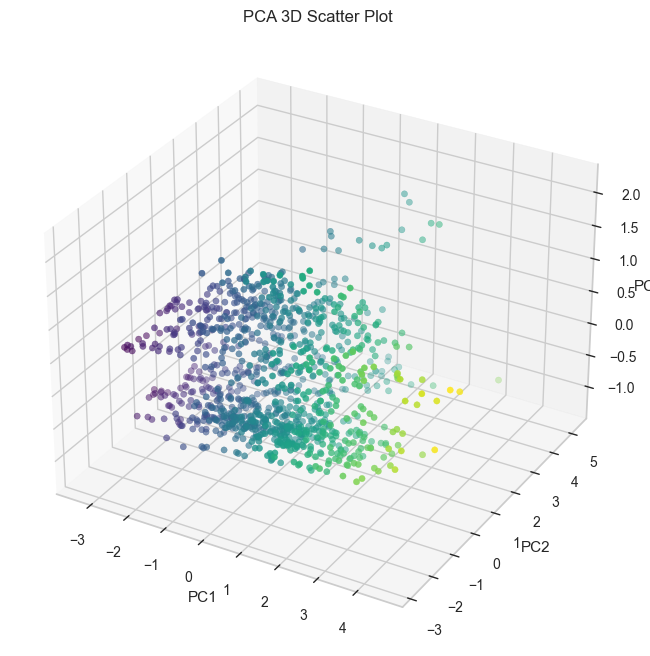

In [65]:
pca = PCA(n_components=3)
df_pca = pca.fit_transform(dataset)


fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")

scatter = ax.scatter3D(df_pca[:, 0], df_pca[:, 1], df_pca[:, 2], c=df_pca[:, 0], cmap='viridis')  # Using PC1 for coloring


ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('PCA 3D Scatter Plot')


# Show the plot
plt.show()

**K-Means clustering**

In the following we will use the Inertia Score to evaluate best K-means model
Inertia measures how well a dataset was clustered by K-Means. It is calculated by measuring the distance between each data point and its centroid, squaring this distance, and summing these squares across one cluster.

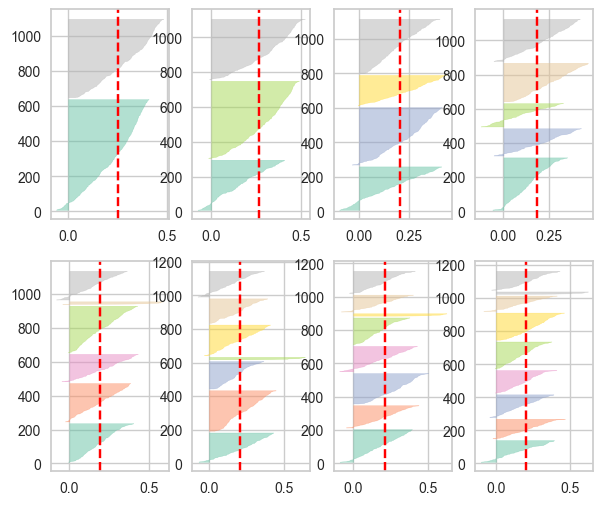

In [49]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(2,4, figsize=(7,6))
for i in [2,3,4,5,6,7,8,9]:
    km = KMeans(n_clusters=i, init = 'k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i-2, 4)  # Adjusted to start indexing from 0 for ax
    
    visualizer = SilhouetteVisualizer(km, colors='Set2', ax=ax[q][mod])
    visualizer.fit(dataset)

In addition, we will check the best silhouette score using Elbow Method on the dataset dataframe.

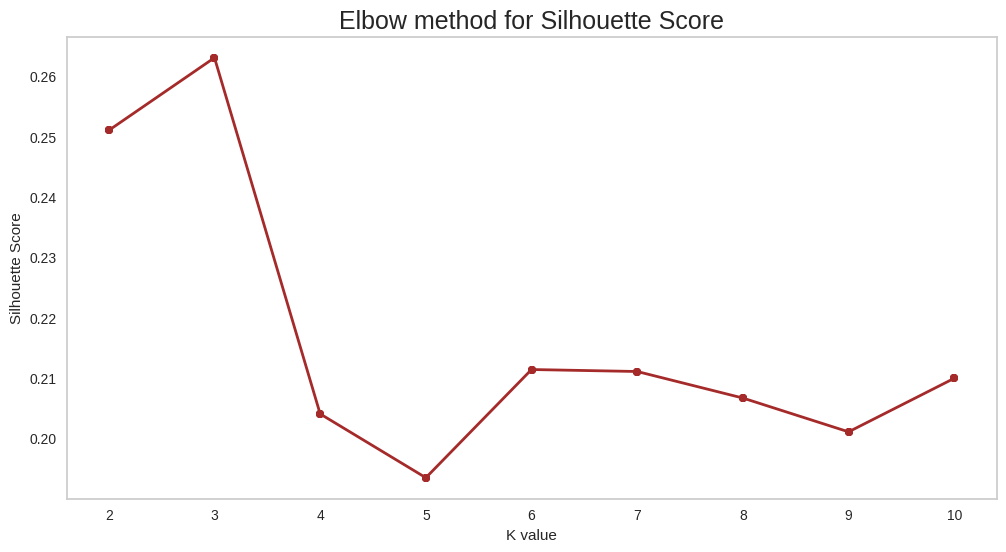

In [128]:
sil = []

for i in [2,3,4,5,6,7,8,9,10]:
    km = KMeans(n_clusters=i, init = 'k-means++', n_init=10, max_iter=100, random_state=42)
    km.fit(dataset)
    sil.append(silhouette_score(dataset, km.predict(dataset)))
    
plt.figure(figsize=(12,6))
plt.grid()
plt.plot([2,3,4,5,6,7,8,9,10], sil, linewidth=2, color='brown', marker = '8')
plt.xlabel('K value')
plt.ylabel('Silhouette Score')
plt.title('Elbow method for Silhouette Score', fontsize=18)
plt.show()

Based on the above we can clearly see that the highest Silhouette Score we can get while running Kmeans clustering using 3 clusters.

C:\Users\gorgi\AppData\Local\Temp\ipykernel_8260\332579328.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10', 3)


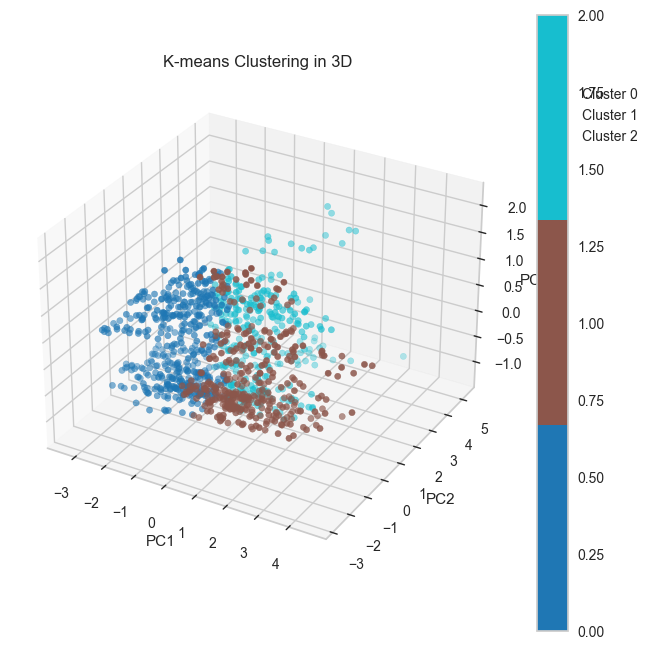

In [64]:
k_means = KMeans(n_clusters=3, random_state=0)
y_pred = k_means.fit_predict(dataset)

pca = PCA(n_components=3)
projection = pca.fit_transform(dataset)

colormap = plt.cm.get_cmap('tab10', 3)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(xs=projection[:, 0], ys=projection[:, 1], zs=projection[:, 2], c=y_pred, cmap=colormap)

cbar = plt.colorbar(scatter)

legend_labels = ['Cluster 0', 'Cluster 1', 'Cluster 2']
ax.legend(handles=scatter.legend_elements()[0], labels=legend_labels, bbox_to_anchor=(1.05, 1)/, loc=2)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('K-means Clustering in 3D')

plt.show()


DBSCAN clustering presented in 3d

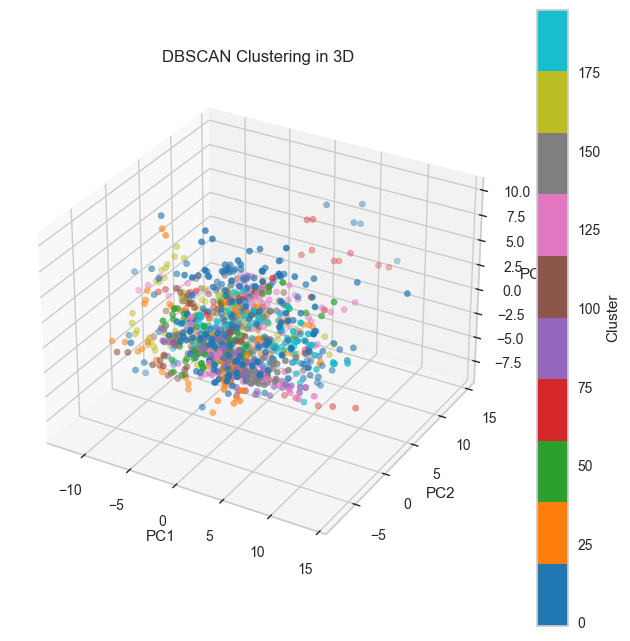

In [58]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

scaler = StandardScaler()
dataset_scaled = scaler.fit_transform(dataset)


pca = PCA(n_components=3)
projection = pca.fit_transform(dataset_scaled)

dbscan = DBSCAN(eps=3, min_samples=2)
y_pred = dbscan.fit_predict(dataset_scaled)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(xs=projection[:, 0], ys=projection[:, 1], zs=projection[:, 2], c=y_pred, cmap="tab10")

cbar = plt.colorbar(scatter)
cbar.set_label('Cluster')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('DBSCAN Clustering in 3D')

plt.show()

In [33]:
from sklearn.metrics import silhouette_score

kmeans_silhouette = silhouette_score(dataset, k_means.labels_)

dbscan_silhouette = silhouette_score(dataset, dbscan.labels_)

print(f"Silhouette Score (K-means): {kmeans_silhouette}")
print(f"Silhouette Score (DBSCAN): {dbscan_silhouette}")


Silhouette Score (K-means): 0.2631089765991567
Silhouette Score (DBSCAN): 0.10099883688249829


# Based on the silhouette scores obtained, we can draw the following conclusions:

K-means clustering achieved a silhouette score of 0.2649, indicating a moderate level of clustering quality. The samples within the clusters are relatively compact and well-separated from other clusters.

DBSCAN clustering obtained a silhouette score of 0.1009, which suggests a lower level of clustering quality compared to K-means. The clusters generated by DBSCAN may have overlapping or widely spread data points.

Therefore, based on the silhouette scores, K-means clustering seems to have performed better than DBSCAN in this particular dataset. However, it's important to note that these results are specific to the given dataset and the chosen parameters for the algorithms.